In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
def TVAR(p,array,tail):
    if tail == "lower":
        arr = array[:int(p*len(array))+1]
    else:
        arr = array[int(p*len(array))+1:]
    CTE = sum(arr) / len(arr)
    return CTE


In [7]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    returns[x] = t0.pct_change().iloc[::3][1:]
    df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][:len(t0)]]
    df.reset_index(drop = True,inplace = True)
    df["t0"] = np.sign(t0.pct_change()[1:])
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    np.random.seed(10)
    for i in range(len(df)):
        if df["t0"][i] == 0:
            q = st.bernoulli.rvs(0.5)
            if q == 0:
                df["t0"][i] = -1
            else:
                df["t0"][i] = 1
                
    df["t1"] = df["t0"].shift(-3)
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace = True)
    
    states = ["Up","Down"]
    TM = pd.DataFrame(index = ["Up","Down"])
    
    tm = {"UU":0,"UD":0,"DU":0,"DD":0}
    
    for i in range(2,len(df)):
        
        if df["t0"][i] == 1 and df["t0"][i-1] == 1:
            tm["UU"] += 1
        elif df["t0"][i] == -1 and df["t0"][i-1] == 1:
            tm["UD"] += 1
        elif df["t0"][i] == 1 and df["t0"][i-1] == -1:
            tm["DU"] += 1
        else:
            tm["DD"] += 1
            
    TM["Up"] = [tm["UU"],tm["UD"]]
    TM["Down"] = [tm["DU"],tm["DD"]]
    
    findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
    findf.columns = findf.iloc[0]
    findf.drop([0,1],inplace=True)
    
    findf1 = pd.DataFrame()
    findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
    try:
        findf1["PeRatio"] = np.log(findf["PeRatio"].str.replace(',', '').astype(float))
    except:
        findf1["PeRatio"] = np.log(findf["PegRatio"].str.replace(',', '').astype(float))
    findf1['MarketCap'] = np.log(findf['MarketCap'].str.replace(',', '').astype(float))
    findf1.interpolate(method='linear',inplace=True)
    
    findf1.dropna(inplace=True)
    findf1.reset_index(drop = True,inplace = True)
    
    alldf = df.merge(right=findf1, on = ["MMYYYY"])
    
    all_tm[x] = scaleMatrix(TM)
    all_data[x] = alldf

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
l = 0
for x in all_data.keys():
    l+= len(all_data[x])
l

9175

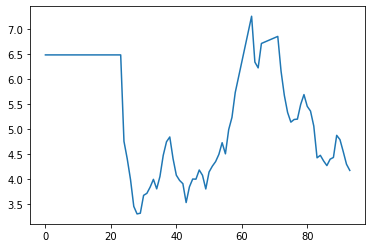

In [9]:
plt.plot([x for x in range(len(all_data["AMZN"]))], all_data["AMZN"]["PeRatio"])

In [10]:
all_data

{'AAPL':      MMYYYY   t0   t1   PeRatio  MarketCap
 0    091985  1.0  1.0  2.949112  21.294182
 1    121985  1.0  1.0  2.755824  21.549129
 2    031986  1.0 -1.0  2.636124  21.464268
 3    061986 -1.0 -1.0  2.825833  21.670385
 4    091986 -1.0  1.0  3.274651  22.119388
 ..      ...  ...  ...       ...        ...
 137  122019  1.0 -1.0  3.350676  28.077488
 138  032020 -1.0  1.0  3.558799  28.307062
 139  062020  1.0 -1.0  3.700166  28.434044
 140  092020 -1.0  1.0  3.494232  28.343104
 141  122020  1.0  1.0  3.422306  28.449760
 
 [142 rows x 5 columns], 'ADBE':      MMYYYY   t0   t1   PeRatio  MarketCap
 0    111986  1.0  1.0  4.591923  20.029024
 1    021987  1.0 -1.0  3.683515  19.629814
 2    051987 -1.0 -1.0  3.216112  19.313283
 3    081987 -1.0  1.0  3.107229  19.491514
 4    111987  1.0  1.0  3.302408  19.690969
 ..      ...  ...  ...       ...        ...
 132  112019  1.0 -1.0  4.070325  25.946687
 133  022020 -1.0  1.0  4.215529  26.230332
 134  052020  1.0  1.0  4.098685  

In [11]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
ps = []
mc = []
for x in tick["Ticker"]:
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    ps.extend([x for x in all_data[x]["PeRatio"]])
    mc.extend([x for x in all_data[x]["MarketCap"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["PeRatio"] = ps
npdf["MarketCap"] = mc
npdf.head()

,Ticker,MMYYYY,t0,t1,PeRatio,MarketCap
0,AAPL,091985,1.0,1.0,2.949112,21.294182
1,AAPL,121985,1.0,1.0,2.755824,21.549129
2,AAPL,031986,1.0,-1.0,2.636124,21.464268
3,AAPL,061986,-1.0,-1.0,2.825833,21.670385
4,AAPL,091986,-1.0,1.0,3.274651,22.119388


In [12]:
np.random.seed(20)
test_comps = np.random.choice(tick["Ticker"],4, replace = False)

test = npdf.iloc[np.where(np.logical_or(np.logical_or(np.logical_or(
    npdf["Ticker"] == test_comps[0],
    npdf["Ticker"] == test_comps[1]),
    npdf["Ticker"] == test_comps[2]),
    npdf["Ticker"] == test_comps[3]))]
train = npdf.iloc[np.where(np.logical_and(np.logical_and(np.logical_and(
    npdf["Ticker"] != test_comps[0],
    npdf["Ticker"] != test_comps[1]),
    npdf["Ticker"] != test_comps[2]),
    npdf["Ticker"] != test_comps[3]))]
train.reset_index(drop = True,inplace = True)
test.reset_index(drop = True,inplace = True)
test_comps

array(['INCY', 'IDXX', 'ADI', 'KHC'], dtype=object)

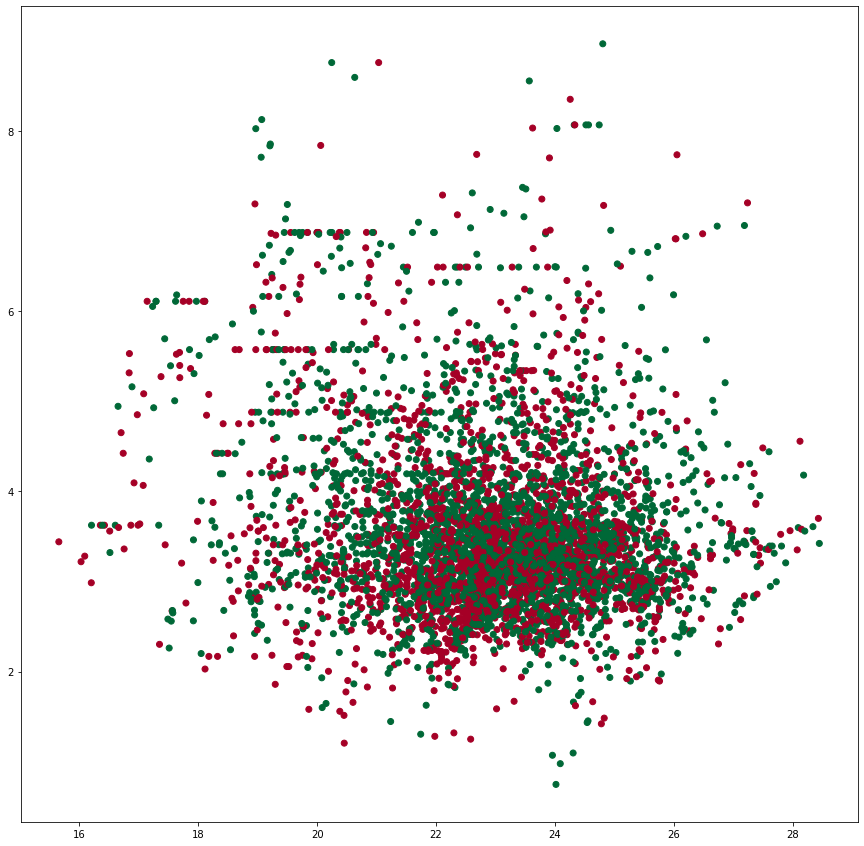

In [13]:
npdfu = train.loc[npdf["t0"] == 1]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(npdfu["MarketCap"],npdfu["PeRatio"], c = npdfu["t1"],cmap = "RdYlGn")
plt.show()

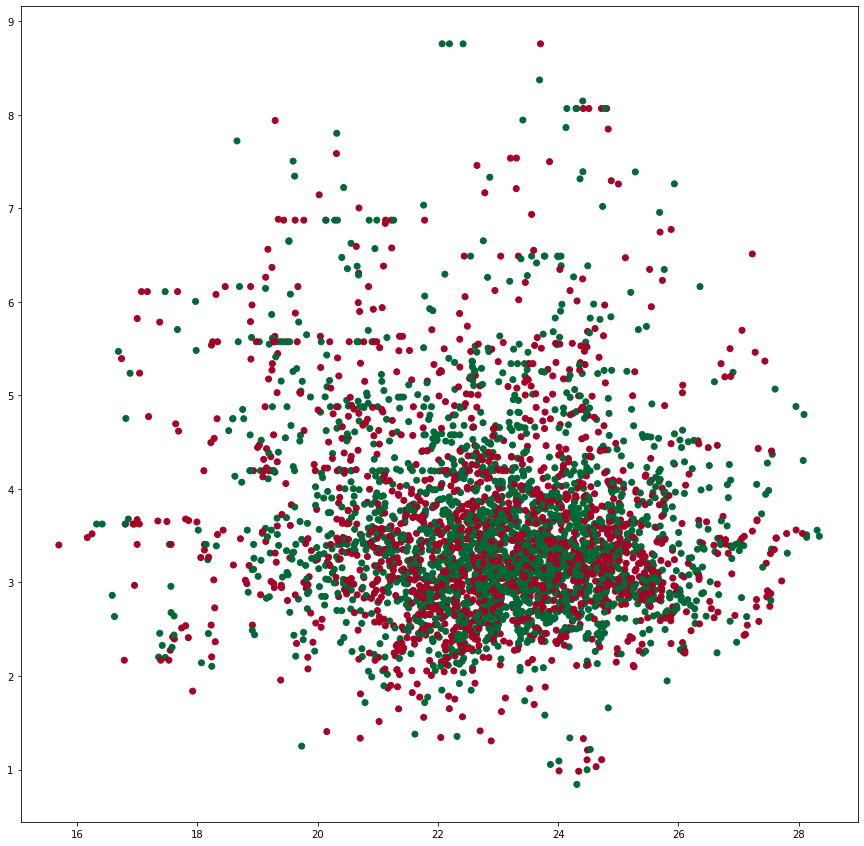

In [14]:
npdfd = train.loc[npdf["t0"] == -1]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(npdfd["MarketCap"],npdfd["PeRatio"], c = npdfd["t1"],cmap = "RdYlGn")
plt.show()

In [15]:
n_neighbors = 8
scale = pd.DataFrame()
scale["MarketCap"] = norm(npdfu["MarketCap"])
scale["PeRatio"] = norm(npdfu["PeRatio"])
upknn = neighbors.KNeighborsClassifier(n_neighbors)
X = scale[["MarketCap","PeRatio"]]
y = npdfu["t1"]
upknn.fit(X,y)

KNeighborsClassifier(n_neighbors=8)

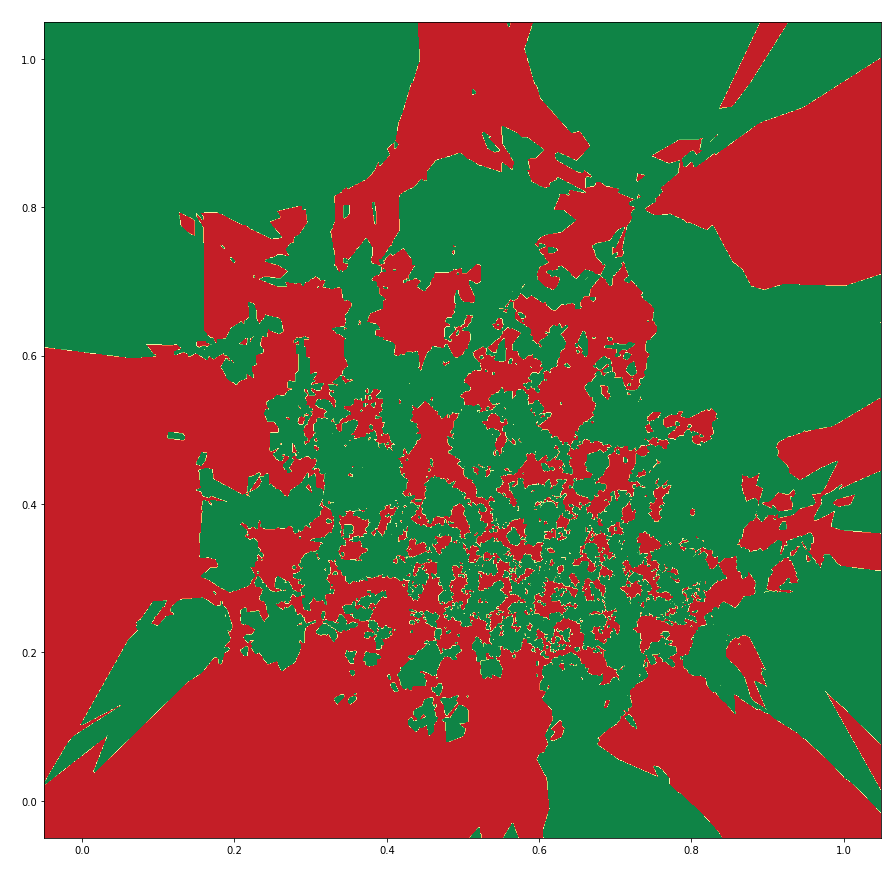

In [16]:
h = 0.001
x_min, x_max = X["MarketCap"].min(), X["MarketCap"].max()
y_min, y_max = X["PeRatio"].min(), X["PeRatio"].max()
xx, yy = np.meshgrid(np.arange(x_min-.05, x_max+.05, h), np.arange(y_min-.05, y_max+.05, h))
Z = upknn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(15, 15))
plt.contourf(xx, yy, Z, cmap="RdYlGn")
#plt.scatter(X["Log MarketCap"],X["Log Price/Sales"], cmap = "RdYlGn", c = y,alpha = 0.8)
plt.title("Class based on Market Capitalization and P/E Ratio - Returns Initially Positive", c = "white", loc="left")
plt.xlabel("Market Capitalization", c = "white")
plt.ylabel("Price to Earnings Ratio", c = "white")
plt.show()

In [17]:
scale = pd.DataFrame()
scale["MarketCap"] = norm(npdfd["MarketCap"])
scale["PeRatio"] = norm(npdfd["PeRatio"])
downknn = neighbors.KNeighborsClassifier(n_neighbors)
X = scale[["MarketCap","PeRatio"]]
y = npdfd["t1"]
downknn.fit(X,y)

KNeighborsClassifier(n_neighbors=8)

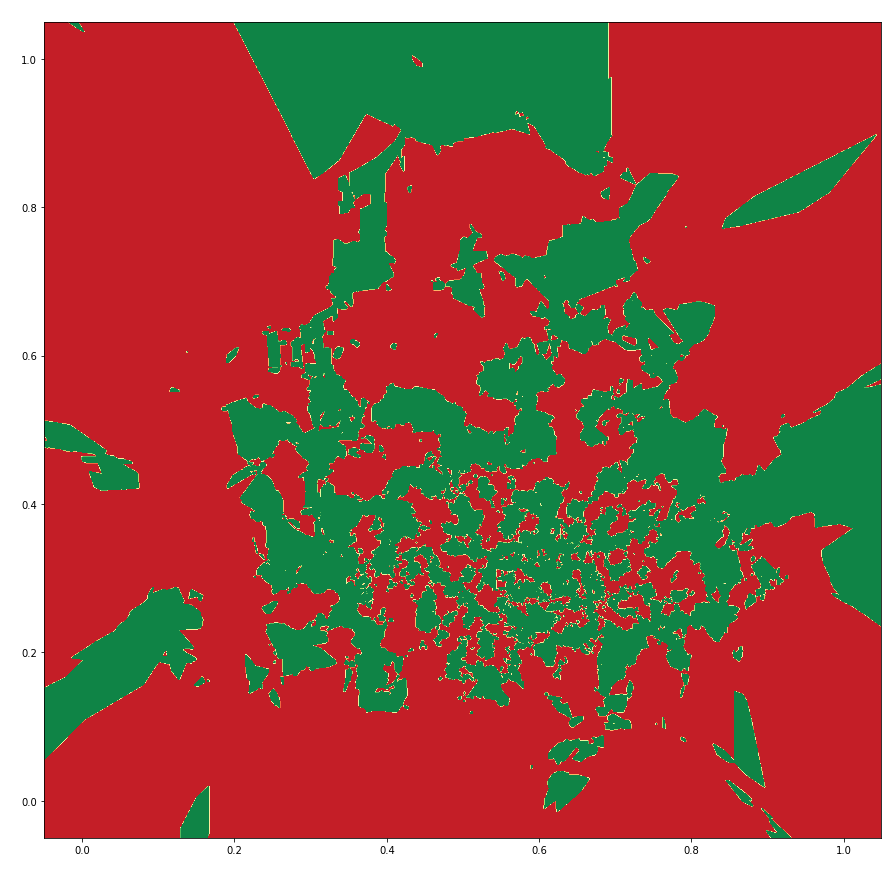

In [18]:
h = 0.001
x_min, x_max = X["MarketCap"].min(), X["MarketCap"].max()
y_min, y_max = X["PeRatio"].min(), X["PeRatio"].max()
xx, yy = np.meshgrid(np.arange(x_min-.05, x_max+.05, h), np.arange(y_min-.05, y_max+.05, h))
Z = downknn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(15, 15))
plt.contourf(xx, yy, Z, cmap="RdYlGn")
#plt.scatter(X["Log MarketCap"],X["Log Price/Sales"], cmap = "RdYlGn", c = y,alpha = 0.8)
plt.title("Class based on Market Capitalization and P/E Ratio - Returns Initially Negative", c = "white", loc="left")
plt.xlabel("Log Market Capitalization", c = "white")
plt.ylabel("Log Price to Earnings", c = "white")
plt.show()

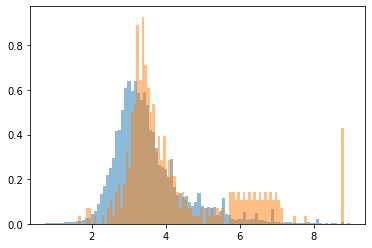

count    8785.000000
mean        3.552813
std         1.003765
min         0.748109
25%         2.922301
50%         3.332562
75%         3.929529
max         8.966867
Name: PeRatio, dtype: float64

In [19]:
plt.hist(train["PeRatio"],bins=100,density = True,alpha = 0.5)
plt.hist(test["PeRatio"],bins=100,density = True,alpha=0.5)
plt.show()
train["PeRatio"].describe()

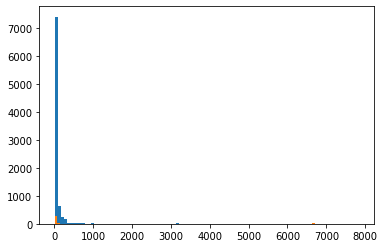

count    8785.000000
mean        1.232412
std         0.261415
min        -0.290207
25%         1.072371
50%         1.203741
75%         1.368520
max         2.193536
Name: PeRatio, dtype: float64

In [20]:
plt.hist(np.exp(train["PeRatio"]),bins=100)
plt.hist(np.exp(test["PeRatio"]),bins=100)
plt.show()
np.log(train["PeRatio"]).describe()

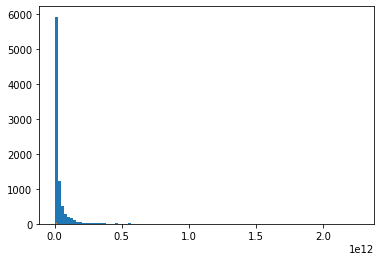

count    8.785000e+03
mean     4.257280e+10
std      1.264896e+11
min      6.276623e+06
25%      3.223628e+09
50%      1.008112e+10
75%      3.209090e+10
max      2.267639e+12
Name: MarketCap, dtype: float64

In [21]:
plt.hist(np.exp(train["MarketCap"]),bins=100)
plt.hist(np.exp(test["MarketCap"]),bins=100)
plt.show()
np.exp(train["MarketCap"]).describe()

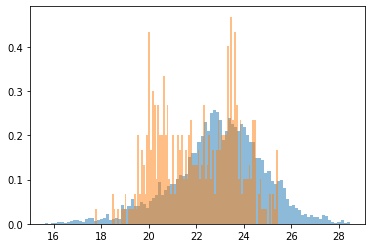

count    8785.000000
mean       22.943661
std         1.898072
min        15.652343
25%        21.893773
50%        23.033931
75%        24.191838
max        28.449760
Name: MarketCap, dtype: float64

In [22]:
plt.hist(train["MarketCap"],bins=100,density = True,alpha = 0.5)
plt.hist(test["MarketCap"],bins=100,density = True,alpha = 0.5)
plt.show()
train["MarketCap"].describe()

In [23]:
p = 12
len(train), len(test)
test

,Ticker,MMYYYY,t0,t1,PeRatio,MarketCap
0,ADI,101985,1.0,-1.0,3.901811,20.734469
1,ADI,011986,-1.0,1.0,3.527448,20.477889
2,ADI,041986,1.0,1.0,3.456979,20.437654
3,ADI,071986,1.0,-1.0,3.567446,20.548122
4,ADI,101986,-1.0,1.0,3.790578,20.653473
...,...,...,...,...,...,...
385,KHC,122019,1.0,-1.0,3.017592,24.386865
386,KHC,032020,-1.0,1.0,3.653979,24.324102
387,KHC,062020,1.0,-1.0,4.290366,24.470159
388,KHC,092020,-1.0,1.0,4.926754,24.613452


In [24]:
k = 0
PDCE = {}
pdce = test.loc[test["Ticker"] == test_comps[0]][["t0","t1","PeRatio","MarketCap"]]
pdce.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(pdce):
    PDCE[i] = pdce.iloc[k:p+k]
    k+=p
    i+=1

In [25]:
k = 0
DQ = {}
dq = test.loc[test["Ticker"] == test_comps[1]][["t0","t1","PeRatio","MarketCap"]]
dq.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(dq):
    DQ[i] = dq.iloc[k:p+k]
    k+=p
    i+=1

In [26]:
k = 0
PLUG = {}
plug = test.loc[test["Ticker"] == test_comps[2]][["t0","t1","PeRatio","MarketCap"]]
plug.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(plug):
    PLUG[i] = plug.iloc[k:p+k]
    k+=p
    i+=1

In [27]:
k = 0
VLO = {}
vlo = test.loc[test["Ticker"] == test_comps[3]][["t0","t1","PeRatio","MarketCap"]]
vlo.reset_index(drop = True,inplace = True)
i=0
while p+k <= len(vlo):
    VLO[i] = vlo.iloc[k:p+k]
    k+=p
    i+=1

In [28]:
len(PDCE),len(DQ),len(PLUG),len(VLO)

(9, 9, 11, 1)

In [29]:
def proj(inp,X1,X2,n,start_state_col):
    sts = []
    inp.reset_index(drop = True,inplace = True)
    curr_st = inp[start_state_col].iloc[0]
    for step in range(n):
        sts.append(curr_st)
        if curr_st == -1:
            up_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            down_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[-1] / n_neighbors
            curr_st = np.random.choice([-1,1],1,p = [down_prob, up_prob])[0]
        else:
            up_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            down_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[-1] / n_neighbors
            curr_st = np.random.choice([-1,1],1,p = [down_prob, up_prob])[0]
    return sts

In [30]:
PDCE[0]["t1"]

0     1.0
1    -1.0
2     1.0
3    -1.0
4     1.0
5     1.0
6     1.0
7    -1.0
8     1.0
9     1.0
10    1.0
11   -1.0
Name: t1, dtype: float64

In [31]:
np.random.seed(10)
testloss = []
n = 100
for j in range(len(PDCE)):
    for i in range(n):
        out = proj(PDCE[j],"PeRatio","MarketCap",len(PDCE[j]),"t0")
        testloss.append(hamming_loss(out[1:],PDCE[j]["t1"][1:]))
for j in range(len(DQ)):
    for i in range(n):
        out = proj(DQ[j],"PeRatio","MarketCap",len(DQ[j]),"t0")
        testloss.append(hamming_loss(out[1:],DQ[j]["t1"][1:]))
for j in range(len(PLUG)):
    for i in range(n):
        out = proj(PLUG[j],"PeRatio","MarketCap",len(PLUG[j]),"t0")
        testloss.append(hamming_loss(out[1:],PLUG[j]["t1"][1:]))
for j in range(len(VLO)):
    for i in range(n):
        out = proj(VLO[j],"PeRatio","MarketCap",len(VLO[j]),"t0")
        testloss.append(hamming_loss(out[1:],VLO[j]["t1"][1:]))

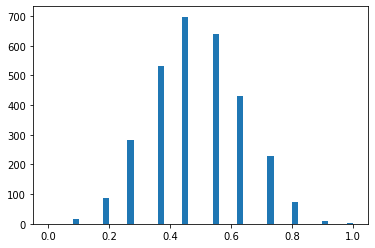

count    3000.000000
mean        0.488788
std         0.150437
min         0.000000
10%         0.272727
20%         0.363636
30%         0.363636
40%         0.454545
50%         0.454545
60%         0.545455
70%         0.545455
80%         0.636364
90%         0.727273
max         1.000000
dtype: float64

In [32]:
plt.hist(testloss, bins = 50)
plt.show()
testloss = pd.Series(testloss)
testloss.describe(percentiles = [0.1+0.1*i for i in range(9)])

In [33]:
TM = pd.DataFrame(index = [1,-1])

tm = {"UU":0,"UD":0,"DU":0,"DD":0}

for x in tick["Ticker"]:
    if x not in test_comps:
        tm["UU"] += all_tm[x]["Up"]["Up"]
        tm["DU"] += all_tm[x]["Down"]["Up"]
        tm["UD"] += all_tm[x]["Up"]["Down"]
        tm["DD"] += all_tm[x]["Down"]["Down"]
TM[1] = [tm["UU"],tm["UD"]]
TM[-1] = [tm["DU"],tm["DD"]]

In [34]:
TM = scaleMatrix(TM)
TM

,1,-1
1,0.585497,0.414503
-1,0.586654,0.413346


In [35]:
TM[1][1] + TM[-1][1], TM[-1][-1] + TM[1][-1]

(1.0, 1.0)

In [36]:
np.random.seed(10)
ptspdce = {}
for i in range(len(PDCE)):
    ptspdce[i] = pd.DataFrame()
    ptspdce[i]["t0"] = [PDCE[i]["t0"][0]]
    
ptsdq = {}
for i in range(len(DQ)):
    ptsdq[i] = pd.DataFrame()
    ptsdq[i]["t0"] = [DQ[i]["t0"][0]]
    
ptsplug = {}
for i in range(len(PLUG)):
    ptsplug[i] = pd.DataFrame()
    ptsplug[i]["t0"] = [PLUG[i]["t0"][0]]

ptsvlo = {}
for i in range(len(VLO)):
    ptsvlo[i] = pd.DataFrame()
    ptsvlo[i]["t0"] = [VLO[i]["t0"][0]]

ptsloss = []
for j in range(len(PDCE)):
    for i in range(n):
        out = chain(init_state = ptspdce[j], matrix = TM, original_states = [1,-1], init_state_col = "t0",n=len(PDCE[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],PDCE[j]["t1"][1:]))
for j in range(len(DQ)):
    for i in range(n):
        out = chain(init_state = ptsdq[j], matrix = TM, original_states = [1,-1], init_state_col = "t0",n=len(DQ[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],DQ[j]["t1"][1:]))
for j in range(len(PLUG)):
    for i in range(n):
        out = chain(init_state = ptsplug[j], matrix = TM, original_states = [1,-1], init_state_col = "t0",n=len(PLUG[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],PLUG[j]["t1"][1:]))
for j in range(len(VLO)):
    for i in range(n):
        out = chain(init_state = ptsvlo[j], matrix = TM, original_states = [1,-1], init_state_col = "t0",n=len(VLO[j])-1)
        ptsloss.append(hamming_loss(out.iloc[0][1:],VLO[j]["t1"][1:]))

In [37]:
len(ptspdce),len(ptsdq),len(ptsplug),len(ptsvlo)

(9, 9, 11, 1)

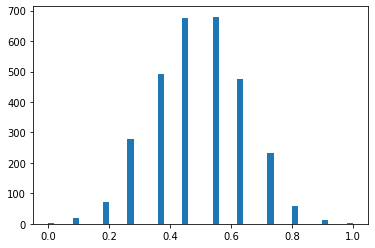

count    3000.000000
mean        0.493848
std         0.149037
min         0.000000
10%         0.272727
20%         0.363636
30%         0.454545
40%         0.454545
50%         0.454545
60%         0.545455
70%         0.545455
80%         0.636364
90%         0.727273
max         1.000000
dtype: float64

In [38]:
plt.hist(ptsloss, bins = 50)
plt.show()
ptsloss = pd.Series(ptsloss)
ptsloss.describe(percentiles = [0.1+0.1*i for i in range(9)])

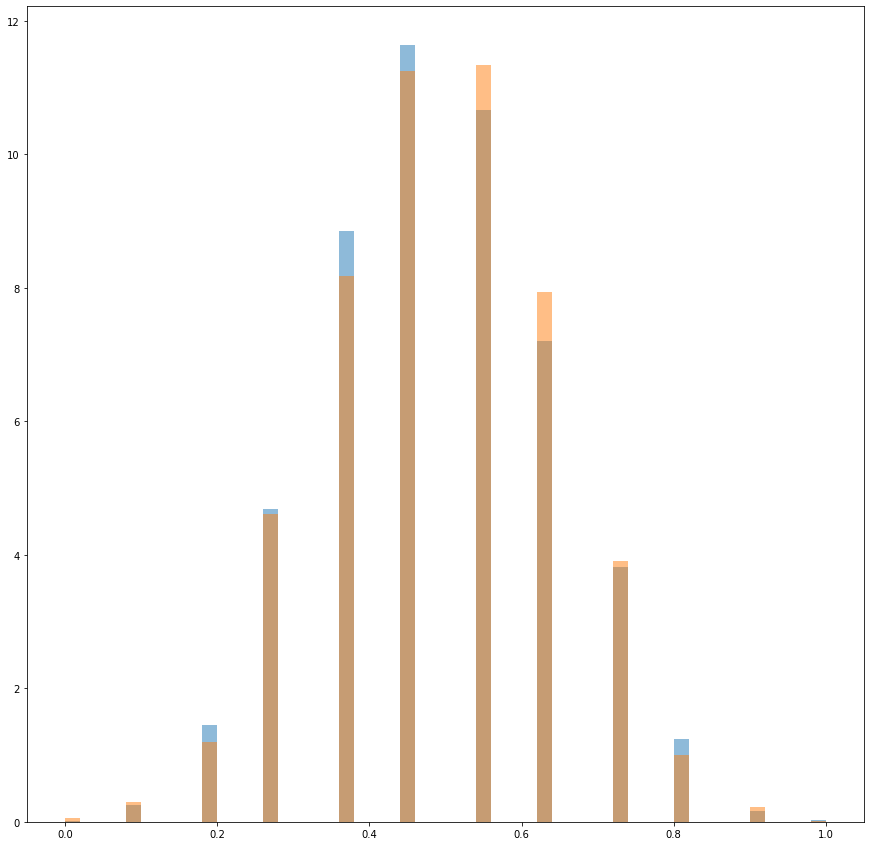

In [39]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.hist(testloss, bins = 50, alpha = 0.5,density=True)
plt.hist(ptsloss, bins = 50,alpha = 0.5,density=True)
plt.show()

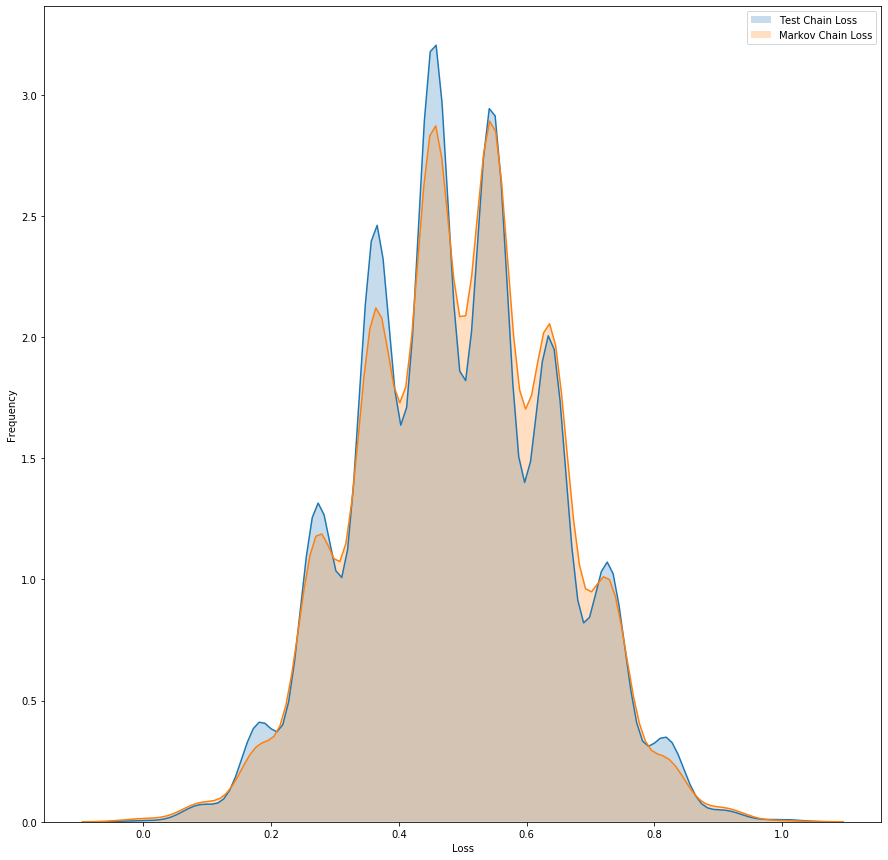

In [40]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
sns.kdeplot(testloss,shade=True)
sns.kdeplot(ptsloss,shade=True)
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend(["Test Chain Loss","Markov Chain Loss"])
plt.show()

In [41]:
corrs = pd.DataFrame(columns=returns.keys(),index=returns.keys())
for a in returns.keys():
    for b in returns.keys():
        corrs[a][b] = round(st.pearsonr(returns[a][:min(len(returns[a]),len(returns[b]))],returns[b][:min(len(returns[a]),len(returns[b]))])[0],2)
        if abs(corrs[a][b]) > 0.5 and a != b and a != 'CRWD' and b != 'CRWD':
            print(corrs[a][b],a,b)

0.51 AAPL DOCU
0.6 AAPL MRNA
0.68 ADI AMAT
0.51 ADI AMD
0.69 ADI KLAC
0.55 ADI LRCX
0.55 ADI PCAR
0.68 ADI TXN
0.67 ADP DOCU
0.53 ADP FOX
0.56 ADP FOXA
0.52 ADP PAYX
-0.52 ADSK FOX
-0.53 ADSK FOXA
-0.79 ADSK PDD
0.62 AEP EXC
0.65 AEP XEL
-0.59 ALGN PTON
-0.54 ALGN ZM
0.68 AMAT ADI
0.56 AMAT AMD
0.65 AMAT INTC
0.77 AMAT KLAC
0.75 AMAT LRCX
0.65 AMAT MU
0.55 AMAT TEAM
0.7 AMAT TXN
0.51 AMD ADI
0.56 AMD AMAT
0.52 AMD KLAC
0.53 AMZN PDD
-0.6 ANSS PTON
0.53 ASML DLTR
0.55 ASML PDD
-0.65 ATVI PTON
-0.62 ATVI ZM
0.51 AVGO FOX
0.57 AVGO FOXA
0.52 AVGO PTON
0.56 BIDU DOCU
0.53 BIDU FOXA
0.51 BIIB FOX
0.58 BKNG DOCU
0.52 BMRN PTON
-0.66 CHKP DOCU
0.6 CHTR FOX
0.65 CHTR FOXA
0.57 CMCSA DOCU
0.67 CMCSA FOX
0.62 CMCSA FOXA
0.65 CPRT FOXA
-0.64 CPRT MRNA
-0.56 CPRT OKTA
0.77 CSX FOX
0.79 CSX FOXA
0.58 CSX PCAR
0.63 CSX PTON
0.53 CSX TEAM
0.71 CTAS FOX
0.72 CTAS FOXA
0.53 CTAS PAYX
0.55 CTAS PCAR
0.53 CTAS PEP
0.53 DLTR ASML
0.51 DOCU AAPL
0.67 DOCU ADP
0.56 DOCU BIDU
0.58 DOCU BKNG
-0.66 DOCU CHKP
0

In [42]:
corrs

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,TMUS,TSLA,TXN,VRSK,VRSN,VRTX,WDAY,XEL,XLNX,ZM
AAPL,1,-0.03,0.33,0.25,-0.17,0.02,0,0.36,0.35,0.23,...,-0.05,0.06,0.29,0.15,0.17,0.08,0.36,0.13,-0.04,-0.03
ADBE,-0.03,1,0.06,0.04,-0.08,-0.11,0.03,0.16,-0.03,-0.04,...,-0.17,-0.28,0.11,0.37,0.1,0.16,-0.1,-0.1,-0.04,-0.22
ADI,0.33,0.06,1,0.45,-0.07,0.08,-0.01,0.68,0.51,0.04,...,-0.16,-0.12,0.68,0.13,0.16,0.04,0.07,0.24,0.06,0.09
ADP,0.25,0.04,0.45,1,-0.1,0.37,0.2,0.39,0.21,0.26,...,-0.26,-0.23,0.29,0.14,0.29,0.13,0.13,0.37,0.1,0.11
ADSK,-0.17,-0.08,-0.07,-0.1,1,-0.02,0.03,-0.26,-0.14,-0.15,...,0.08,0.14,-0.21,-0.33,-0.01,-0.13,-0.08,-0.02,-0.03,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VRTX,0.08,0.16,0.04,0.13,-0.13,-0.03,0.09,0.15,0.06,0.09,...,0.03,-0.21,-0.08,0.09,0.02,1,-0.01,0.03,0.03,0.04
WDAY,0.36,-0.1,0.07,0.13,-0.08,0.02,0.03,0.1,0.17,0.34,...,0.07,-0.02,0.17,-0.09,-0.06,-0.01,1,0.03,0.01,0.35
XEL,0.13,-0.1,0.24,0.37,-0.02,0.65,0.04,0.09,0.05,-0.01,...,-0.13,0.23,0.02,-0.02,0.1,0.03,0.03,1,0.02,0.23
XLNX,-0.04,-0.04,0.06,0.1,-0.03,0.03,-0.1,0.05,-0.08,0,...,-0.06,-0.11,-0,-0.04,0,0.03,0.01,0.02,1,-0.02


In [43]:
testloss.describe(percentiles = [0.1+0.1*i for i in range(9)])

count    3000.000000
mean        0.488788
std         0.150437
min         0.000000
10%         0.272727
20%         0.363636
30%         0.363636
40%         0.454545
50%         0.454545
60%         0.545455
70%         0.545455
80%         0.636364
90%         0.727273
max         1.000000
dtype: float64

In [44]:
ptsloss.describe(percentiles = [0.1+0.1*i for i in range(9)])

count    3000.000000
mean        0.493848
std         0.149037
min         0.000000
10%         0.272727
20%         0.363636
30%         0.454545
40%         0.454545
50%         0.454545
60%         0.545455
70%         0.545455
80%         0.636364
90%         0.727273
max         1.000000
dtype: float64

In [45]:
round(ptsloss.quantile(0.75,'linear')-ptsloss.quantile(0.25,'linear'),2), round(testloss.quantile(0.75,'linear')-testloss.quantile(0.25,'linear'),2)

(0.27, 0.18)

In [46]:
for x in all_data.keys():
    print('-'*30)
    print(x)
    print(round(all_data[x][['PeRatio','MarketCap']].describe(),2))
    print('-'*30)

------------------------------
AAPL
       PeRatio  MarketCap
count   142.00     142.00
mean      3.12      24.33
std       0.70       2.27
min       1.92      21.24
25%       2.63      22.36
50%       2.92      23.35
75%       3.48      26.78
max       5.60      28.45
------------------------------
------------------------------
ADBE
       PeRatio  MarketCap
count   137.00     137.00
mean      3.56      22.86
std       0.61       1.75
min       2.35      19.31
25%       3.09      21.62
50%       3.52      23.23
75%       3.93      23.88
max       5.83      26.23
------------------------------
------------------------------
ADI
       PeRatio  MarketCap
count   142.00     142.00
mean      3.41      22.54
std       0.51       1.46
min       2.42      19.41
25%       3.10      21.67
50%       3.33      23.05
75%       3.67      23.51
max       5.13      24.85
------------------------------
------------------------------
ADP
       PeRatio  MarketCap
count   142.00     142.00
mean      3

max       7.09      24.49
------------------------------
------------------------------
EBAY
       PeRatio  MarketCap
count    89.00      89.00
mean      3.67      24.28
std       1.41       0.49
min       1.62      22.91
25%       2.71      24.02
50%       3.23      24.31
75%       4.44      24.56
max       8.37      25.08
------------------------------
------------------------------
EXC
       PeRatio  MarketCap
count   121.00     121.00
mean      2.76      23.65
std       0.42       0.80
min       2.25      22.20
25%       2.46      22.65
50%       2.68      24.00
75%       2.95      24.27
max       5.33      24.80
------------------------------
------------------------------
FAST
       PeRatio  MarketCap
count   133.00     133.00
mean      3.49      21.83
std       0.26       1.56
min       2.91      17.92
25%       3.30      21.10
50%       3.49      22.20
75%       3.65      23.23
max       4.14      24.12
------------------------------
------------------------------
FB
       

max       8.13      24.32
------------------------------
------------------------------
PCAR
       PeRatio  MarketCap
count   142.00     142.00
mean      2.69      22.57
std       0.58       1.13
min       1.56      20.43
25%       2.33      21.39
50%       2.64      22.92
75%       2.92      23.65
max       4.76      24.20
------------------------------
------------------------------
PDD
       PeRatio  MarketCap
count     8.00       8.00
mean      2.62      24.25
std       0.00       0.87
min       2.62      23.31
25%       2.62      23.69
50%       2.62      23.89
75%       2.62      24.90
max       2.62      25.78
------------------------------
------------------------------
PEP
       PeRatio  MarketCap
count   142.00     142.00
mean      3.12      24.85
std       0.29       0.89
min       2.63      22.64
25%       2.92      24.23
50%       3.08      25.17
75%       3.26      25.49
max       4.17      26.05
------------------------------
------------------------------
PTON
      

In [47]:
per=[]
for x in all_data.keys():
    print('-'*7)
    print(x,":",round(all_data[x][['t0']].count(),0)[0])
    per.append(round(all_data[x][['t0']].count(),0)[0])

-------
AAPL : 142
-------
ADBE : 137
-------
ADI : 142
-------
ADP : 142
-------
ADSK : 106
-------
AEP : 142
-------
ALGN : 80
-------
AMAT : 142
-------
AMD : 142
-------
AMGN : 142
-------
AMZN : 94
-------
ANSS : 98
-------
ASML : 103
-------
ATVI : 105
-------
AVGO : 45
-------
BIDU : 59
-------
BIIB : 67
-------
BKNG : 87
-------
BMRN : 86
-------
CDNS : 134
-------
CDW : 30
-------
CERN : 136
-------
CHKP : 98
-------
CHTR : 44
-------
CMCSA : 101
-------
COST : 138
-------
CPRT : 106
-------
CRWD : 6
-------
CSCO : 124
-------
CSX : 142
-------
CTAS : 142
-------
CTSH : 90
-------
DLTR : 103
-------
DOCU : 3
-------
DXCM : 63
-------
EA : 125
-------
EBAY : 89
-------
EXC : 121
-------
FAST : 133
-------
FB : 34
-------
FISV : 137
-------
FOX : 7
-------
FOXA : 7
-------
GILD : 115
-------
GOOG : 28
-------
GOOGL : 65
-------
HON : 142
-------
IDXX : 118
-------
ILMN : 82
-------
INCY : 108
-------
INTC : 142
-------
INTU : 111
-------
ISRG : 82
-------
JD : 26
-------
KDP : 5

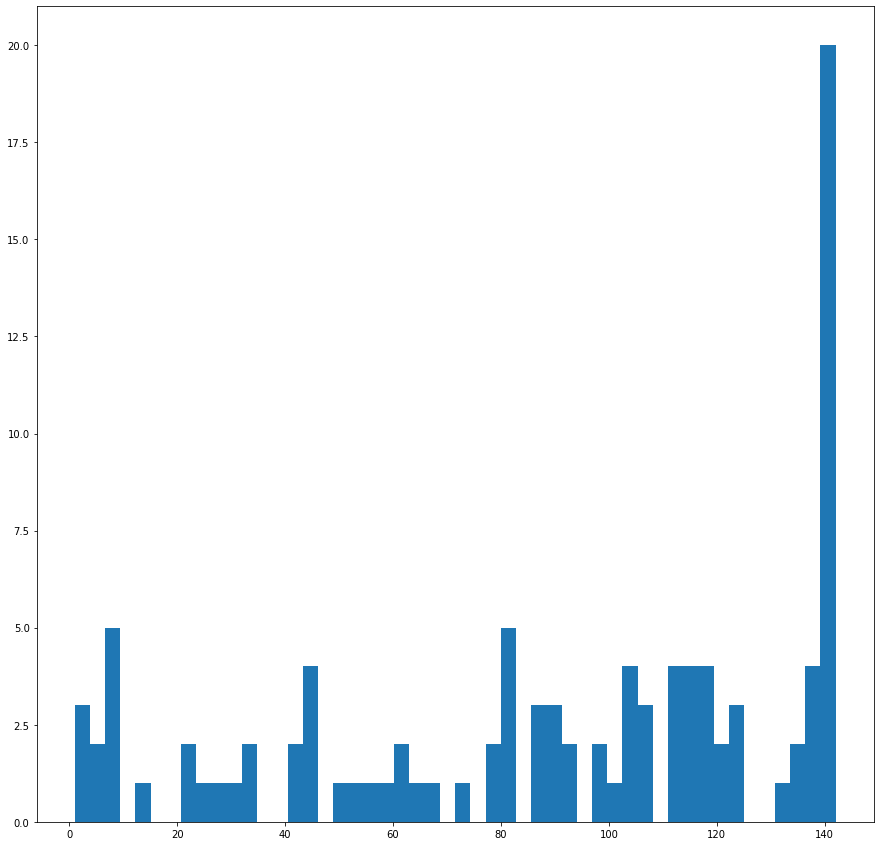

count    102.000000
mean      89.950980
std       45.605579
min        1.000000
10%       13.900000
20%       44.200000
30%       65.600000
40%       86.400000
50%      102.000000
60%      111.000000
70%      121.700000
80%      138.800000
90%      142.000000
max      142.000000
dtype: float64

In [48]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.hist(per,bins=50)
plt.show()
pd.Series(per).describe(percentiles = [0.1+0.1*i for i in range(9)])

In [49]:
for i in range(1,len(out.iloc[0][1:])):
    print(out.iloc[0][1:][i],VLO[j]["t1"][:len(VLO[j])-1][i])

1.0 1.0
-1.0 1.0
1.0 1.0
1.0 1.0
-1.0 -1.0
-1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 -1.0
1.0 1.0
